### Homework 1 (Hierarchy methods)

- Gets data from `Econom_cities_data`
- Use `plot` function from official [sklearn documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_hdbscan.html#sphx-glr-auto-examples-cluster-plot-hdbscan-py).

In [ ]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import warnings
warnings.filterwarnings('ignore')

matplotlib.style.use('ggplot')

In [2]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    # The probability of a point belonging to its labeled cluster determines
    # the size of its marker
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_index = (labels == k).nonzero()[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"k={n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f", {parameters_str}"
    ax.set_title(title)

In [3]:
df = pd.read_csv('../data/Econom_Cities_data.csv', 
                 sep = ';', decimal=',',  index_col='City')
df

,Work,Price,Salary
City,,,
Amsterdam,1714,65.6,49.0
Athens,1792,53.8,30.4
Bogota,2152,37.9,11.5
Bombay,2052,30.3,5.3
Brussels,1708,73.8,50.5
Buenos_Aires,1971,56.1,12.5
Cairo,-9999,37.1,-9999.0
Caracas,2041,61.0,10.9
Chicago,1924,73.9,61.9


Сначала посмотрим на рапределение значений по нашим городам (так как у нас не много городов, можем позволить себе вывести их все на scatterplot)

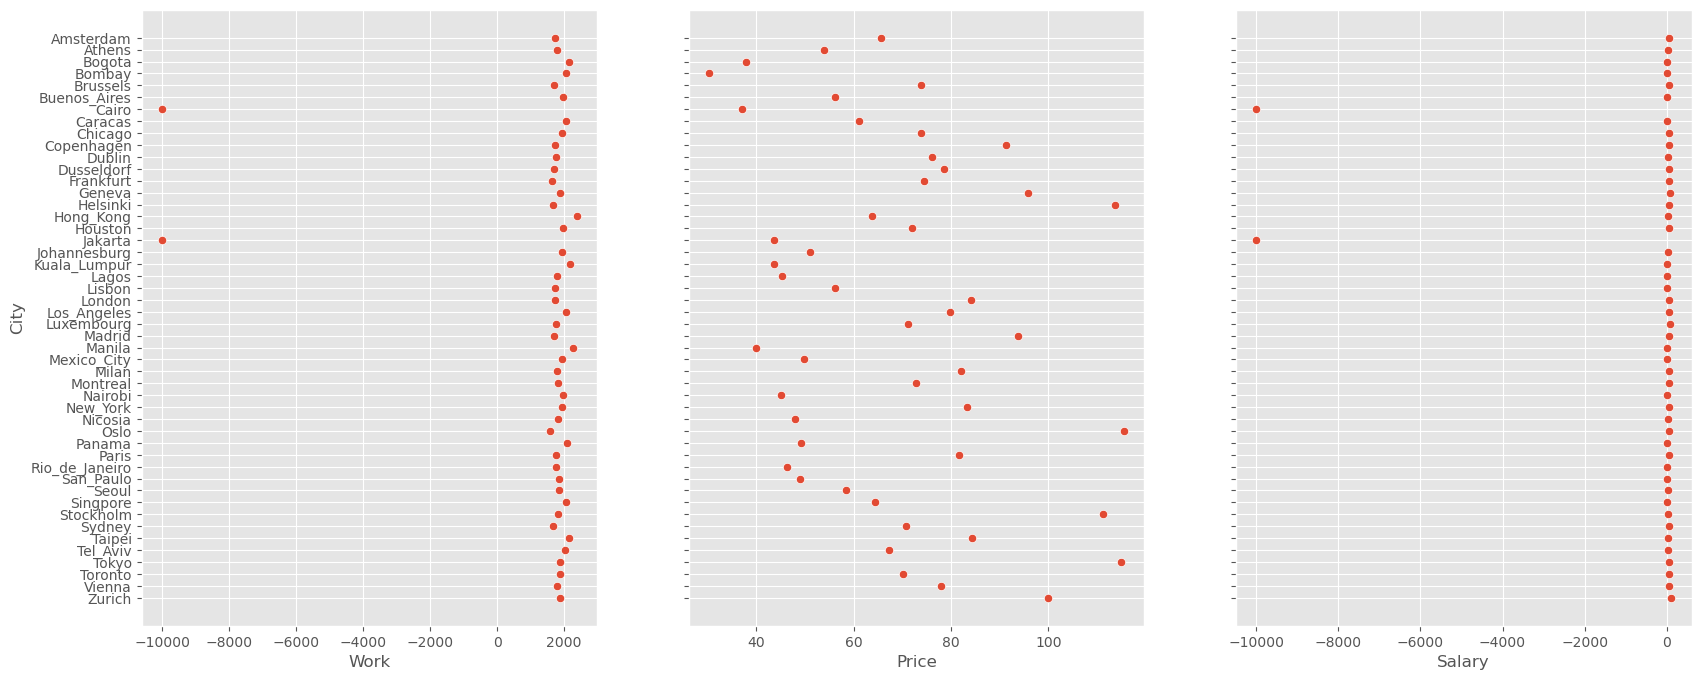

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8), sharey=True)
for i, column in enumerate(df.columns):
    sns.scatterplot(data=df, x=column, y=df.index, ax=axs[i])
plt.show()

Видим, что в городах `Jakarta, Cairo` нерелевантные данные в двух из трёх признаках - отбросим их (так как мы уже потяри болльшую часть информации и дополнять её на основе остальных будет нецелесообразоно).

In [5]:
df_clean = df.drop(['Jakarta', 'Cairo'], axis=0)

Теперь стандартизуем их, чтобы не сравнивать *"килограммы с метрами"*.

In [6]:
scaler2 = StandardScaler()
X = pd.DataFrame(scaler2.fit_transform(df_clean), 
                  index=df_clean.index, 
                  columns=df_clean.columns)

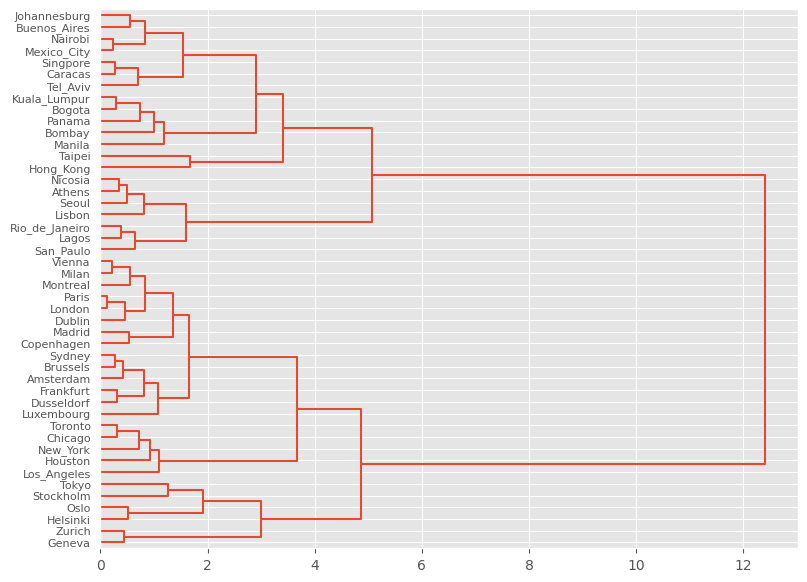

In [7]:
link = linkage(X, 'ward', 'euclidean')

fig = plt.figure(figsize=(9,7))
dn = dendrogram(link,
                labels=df_clean.index.tolist(),
                truncate_mode=None,
                color_threshold=-1,
                orientation = "right",
                leaf_rotation=0.)
plt.show()

Для определения оптимального количества кластеров построим график зависимости растояния между объединяемыми кластерами (второй столбец таблицы link) от шага объединения (гарфик "Каменистой осыпи").

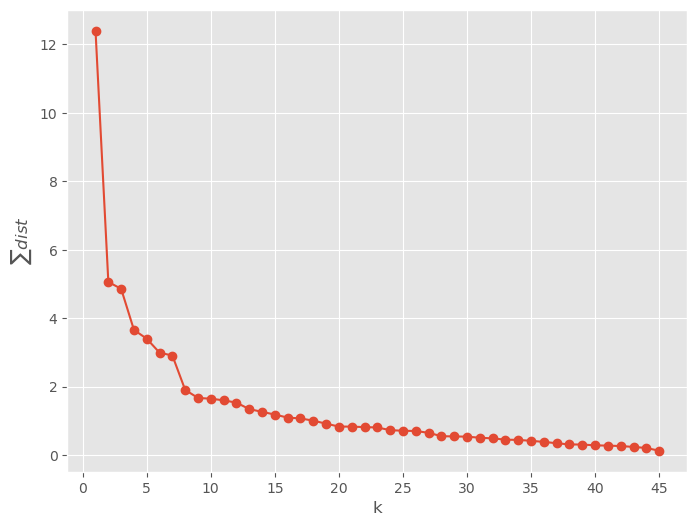

In [ ]:
dist = link[:, 2][::-1]

fig = plt.figure(figsize=(8,6))
plt.plot(np.arange(1, len(dist) + 1), dist, marker='o')

plt.xticks(np.arange(0, len(dist) + 1, 5))
plt.xlabel('k')
plt.ylabel('Dist')

plt.show()

Из графика видно, что после 4го объединения, расстояние перестанет значительно меняться. Таким образом можем поставить ограничение `t=4` для метода иерархической кластеризации (при выбранном `criterion='maxclust'` это даст нам 4 класса).

                Work       Price     Salary
cluster                                    
1        1780.500000  108.550000  71.300000
2        1792.000000   77.526316  55.157895
3        1798.857143   50.942857  19.214286
4        2082.357143   53.121429  14.914286


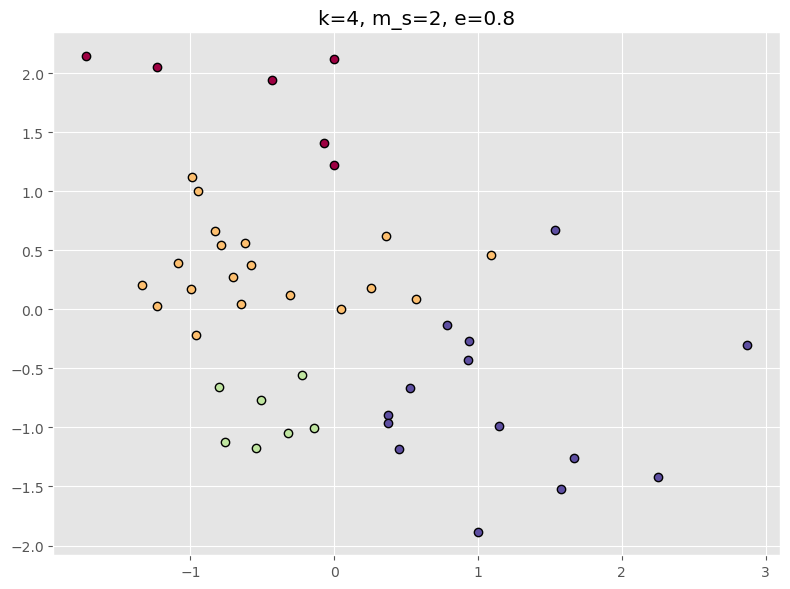

In [13]:
df_clean['cluster'] = fcluster(link, 4, criterion='maxclust')
print(df_clean.groupby('cluster').mean())

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot(X.to_numpy(), df_clean['cluster'].to_numpy(), parameters={"m_s": 2, "e": 0.8}, ax=ax)
plt.tight_layout()
plt.show()

Получили хорошо интерепретируемые результаты: различия между класетрами в среднем прослеживаются явно.

Попробуем добавить 5 кластер.

                Work       Price     Salary
cluster                                    
1        1780.500000  108.550000  71.300000
2        1960.000000   75.820000  59.480000
3        1732.000000   78.135714  53.614286
4        1798.857143   50.942857  19.214286
5        2082.357143   53.121429  14.914286


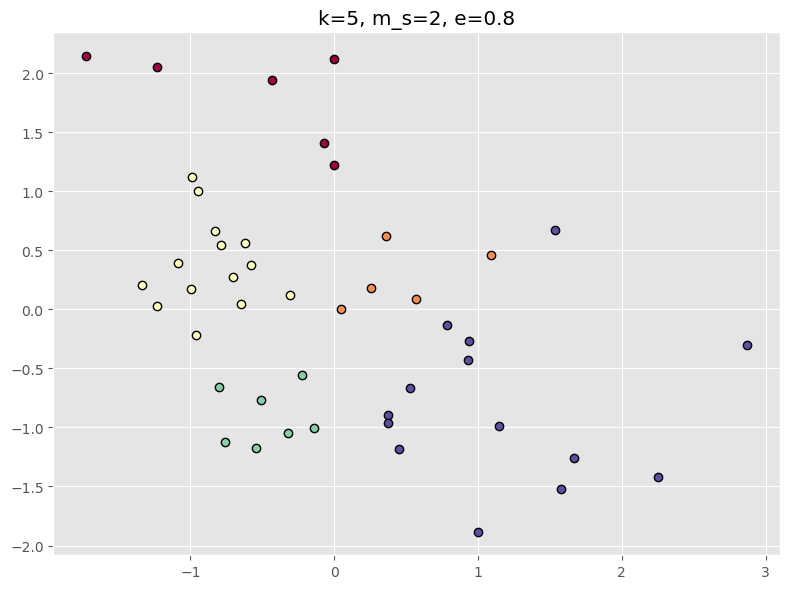

In [14]:
df_clean['cluster'] = fcluster(link, 5, criterion='maxclust')
print(df_clean.groupby('cluster').mean())

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot(X.to_numpy(), df_clean['cluster'].to_numpy(), parameters={"m_s": 2, "e": 0.8}, ax=ax)
plt.tight_layout()
plt.show()

Видим, что *средний* кластер разбился на два отдельных. При этом всё ещё прослеживается явное различие между кластерами.

**Вывод:**

В случае иерархической кластеризации можно получить разные разбиения, каждое из которых может подойти в зависимости от решаемой задачи.

Здесь важно то, что такая кластеризация позвляет проанализировать струкутуру данных. Однако, с данными высокой размерности или с слишком сложной структурой могут возникнуть проблемы.